In [1]:
from shutil import rmtree
from os.path import isdir
from os import mkdir
from sympy import solve, symbols, Eq
from sympy.physics.units import kilo, milli
from sympy.physics.units import convert_to
from sympy.physics.units import ohms, amperes, volts
import ltspice
import platform
import ahkab
import pylab as plt
from IPython import get_ipython

files_directory = "files\\"
fig_directory = "figuras\\"
import matplotlib.pyplot as plot



# ########################################################
#  # Circuitos en DC que evolucionan con el tiempo
# ########################################################


W: Locale appears not set! please export LANG="en_US.UTF-8" or equivalent, 
W: or ahkab's unicode support is broken.


  # Circuitos en DC que evolucionan con el tiempo

  ## Carga de un condensador
  Vamos a ver qué le pasa a un circuito de corriente continua cuando tiene un condensador
  en serie.

  ![](https://raw.githubusercontent.com/pammacdotnet/spicelab/master/condensador%20en%20continua.svg?sanitize=true)

  Al igual que antes, primero guardamos el circuito en un netlist externo:

In [2]:
%%writefile "files\condensador_en_continua.ckt"
* Carga condensador
v1 1 0 type=vdc vdc=6
r1 1 2 1k
c1 2 0 1m ic=0
.op
.tran tstep=0.1 tstop=8 uic=0
.end


Overwriting files\condensador_en_continua.ckt


 > **Pregunta:** ¿qué significa el parámetro `ic=0`?

 **Respuesta:**

 #### ¿qué significa el parámetro `ic=0`?

  La directiva ic permite especificar las condiciones iniciales para el análisis transitorio.
 Fuente: *[IC set initial conditions](http://ltwiki.org/index.php?title=IC_set_initial_conditions)*

 #### ¿qué perseguimos con un análisis de tipo `.tran`?
 Una de las cualidades más interesantes de los condensadores para la electrónica, es que se oponen a los cambios bruscos tensión. Esta cualidad combinada con la de las bobinas, las cuales se oponen a los cambios bruscos de corriente, los convierten en componentes ideales para usarlos como filtros.
 Que se opongan a los cambios de voltaje no significa que lo impidan, lo que sucede es que cuando se da un cambio abrupto de potencial, un condensador aumenta el tiempo que transcurre desde el estado de potencial inicial hasta que se alcanza el nuevo estado de potencial. Esto sucede tanto cuando el cambio de potencial se incrementa o se disminuye. Y el tiempo necesario depende de la capacidad del condensador que en el S.I. se expresa en *faradios* y su símbolo es $\mathrm{F}$.

 Lo comentado implica que el estado del circuito va a cambiar a lo largo del tiempo cuando se dé un cambio de potencial y el análisis del tipo `.tran` nos va a permitir simular justamente eso. Lo configuraremos de modo que se reproduzca un cambio de potencial y capturaremos la evolución del circuito en el tiempo.

 Leamos el circuito:

In [3]:
circuito_y_análisis = ahkab.netlist_parser.parse_circuit("files\condensador_en_continua.ckt")

 Procesamos el circuito con `Ahkab` y extraemos los datos.

In [4]:
# Procesar circuito
circuito_y_análisis = ahkab.netlist_parser.parse_circuit("files\condensador_en_continua.ckt")
# Separar datos netlist y simulaciones
netlist = circuito_y_análisis[0]
análisis_en_netlist = circuito_y_análisis[1]
# Extraer datos de simulaciones
lista_de_análisis = ahkab.netlist_parser.parse_analysis(netlist, análisis_en_netlist)
# Establecer condiciones óptimas para los ánalisis `.dc` y/o `.tran` si lo hay.
for analisis in [d for i, d in enumerate(lista_de_análisis) if "dc" in d.values() or "tran" in d.values()]:
    analisis['outfile'] = files_directory + "simulación_" + analisis['type'] + ".tsv"

  Ejecutamos la simulación

In [5]:
resultados = ahkab.run(netlist, lista_de_análisis)



Starting op analysis:
Calculating guess: skipped. (linear circuit)
Solving...   done.
Solving...   done.
Difference check within margins.
(Voltage: er=0.001, ea=1e-06, Current: er=0.001, ea=1e-09)
Starting transient analysis: 
Selected method: TRAP
Solving...  done.
Average time step: 0.0869565


 Imprimir los resultados de los análisis.

In [6]:
print(resultados['op'])


OP simulation results for '* carga condensador'(netlist files\condensador_en_continua.ckt).
Run on 2020-12-20 08:37:32, data file None.
Variable    Units      Value    Error    %
----------  -------  -------  -------  ---
V1          V              6   -6e-12    0
V2          V              6   -6e-12    0
I(V1)       A              0    0        0


  Dibujamos la gráfica de carga del condensador con el tiempo, centrándonos en la intensidad que circula por la pila.

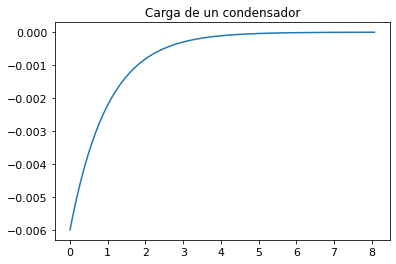

In [7]:
figura = plt.figure()
plt.title("Carga de un condensador")
plt.plot(resultados['tran']['T'], resultados['tran']
         ['I(V1)'], label="Una etiqueta")


 #### **Pregunta:**

 > Etiqueta los ejes convenientemente y comenta la gráfica. Dibuja otra gráfica con el voltaje en el borne `V1`. ¿Por qué son *opuestas*? ¿Qué le ocurre al voltaje a medida que evoluciona el circuito en el tiempo? Dibuja las gráficas en un formato estándar de representación vectorial (SVG, por ejemplo). Algo de ayuda [aquí](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.set_matplotlib_formats). ¿Qué valores devuelve el análisis de tipo `.op`? Justifícalo.

 #### **Respuesta**

 #### Etiqueta los ejes convenientemente y comenta la gráfica:

 Ademas de etiquetar los ejes, para una mayor claridad, también vamos a remapear los datos a valores absolutos.

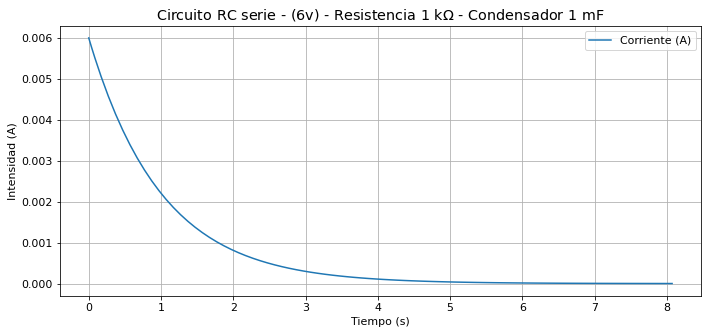

In [8]:
plot.rcParams['figure.figsize'] = [10.0, 4.8]
plot.rcParams['font.size'] = 12
# plot.rcParams['legend.fontsize'] = 'large'
# plot.rcParams['figure.titlesize'] = 'medium'
fig, ax = plot.subplots()
ax.set(xlabel='Tiempo (s)', 
    ylabel='Intensidad (A)', 
    title='Circuito RC serie - ($\mathrm{6v}$) - Resistencia $\mathrm{1\ k\Omega}$ - Condensador $\mathrm{1\ mF}$')
x = resultados['tran']['T']
y = resultados['tran']['I(V1)']
f = lambda x: -x if x < 0 else x
y = list(map(f, y))


ax.grid()
line, = ax.plot(x, y)
line.set_label('Corriente (A)')
plot.legend()
plot.tight_layout()
plot.show()
# Guardar figura en un archivo vectorial
fig.savefig('figuras\\fig_current_RC.svg', transparent='true', format='svg')


 Se aprecia en la gráfica como la corriente inicial es de $\mathrm{6\ mA}$ aproximadamente y disminuye dibujando una curva que se aproxima asintóticamente a cero.

 Como ya hemos comentado anteriormente, los condensadores se oponen a los cambios bruscos de voltaje. Puesto que se han configurado las condiciones iniciales del condensador como sin carga, el inicio de la simulación es equivalente a encender la pila, estando previamente apagada y el condensador sin carga. Por lo que se da un cambio instantaneo de potencial en el circuito pasando de $\mathrm{0\ v}$ a $\mathrm{6\ v}$.

 Conforme se va cargando el condensador aumenta la impedancia (*resistencia*) de este, que al estar en serie con una resistencia (habitualmente llamada limitadora de corriente), la resistencia total aumenta con el tiempo, y la Ley de Ohm dice que si aumenta la resistencia la corriente disminuye, y esto es exactamente lo que vemos en la gráfica.

 #### Dibuja otra gráfica con el voltaje en el borne `V1`. ¿Por qué son *opuestas*? ¿Qué le ocurre al voltaje a medida que evoluciona el circuito en el tiempo?

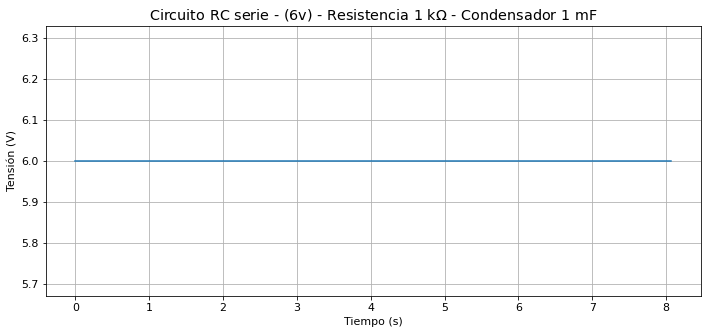

In [9]:
fig, ax = plot.subplots()
ax.set(xlabel='Tiempo (s)', 
    ylabel='Tensión (V)', 
    title='Circuito RC serie - ($\mathrm{6v}$) - Resistencia $\mathrm{1\ k\Omega}$ - Condensador $\mathrm{1\ mF}$')
x = resultados['tran']['T']
y = resultados['tran']['V1']
f = lambda x: -x if x < 0 else x
y = list(map(f, y))
ax.grid()
ax.plot(x, y)
plot.tight_layout()
plot.show()
# Guardar figura en un archivo vectorial
fig.savefig('figuras\\fig_volt_RC.svg', transparent='true', format='svg')


 Las gráficas no son *opuestas*, y no deben serlo, puesto que `V1` es la salida de la pila, que en condiciones ideales es capaz de suministrar la corriente demandada y el voltaje se mantiene constante.

 ¿Como es esto posible? ¿Como puede variar la corriente y mantenerse la tensión constante? El motivo, es que la diferencia de potencial varía entre los extremos de la resistencia, pero no entre los extremos del circuito. Es decir, varia el voltaje entre los nodos 1 y 2 y entre los nodos 2 y 0, pero no entre los nodos 1 y 0, que es lo que la gráfica está mostrando.

 Dibujemos las gráficas del voltaje de la resistencia y del condensador para ver esto más claro. Y porque probablemente es a esto a lo que la pregunta se refiere.

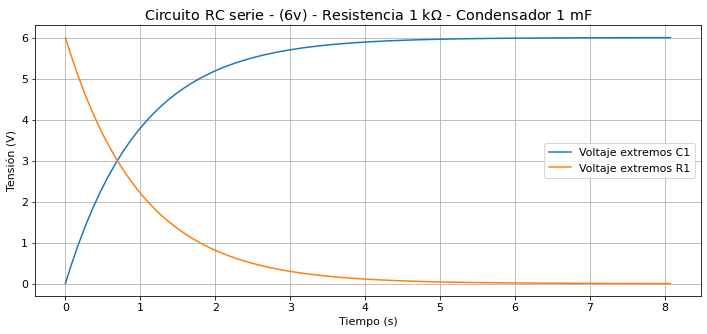

In [10]:
fig, ax = plot.subplots()
tiempo = resultados['tran']['T']
v1 = resultados['tran']['V1']
v_C1 = resultados['tran']['V2']
f = lambda a,b: a - b
v_R1 = list(map(f, v1, v_C1))

ax1 = plot.subplot(111)
line_C1, = ax1.plot(tiempo, v_C1)
line_C1.set_label('Voltaje extremos C1')

ax1.set(xlabel='Tiempo (s)', 
    ylabel='Tensión (V)', 
    title='Circuito RC serie - ($\mathrm{6v}$) - Resistencia $\mathrm{1\ k\Omega}$ - Condensador $\mathrm{1\ mF}$')

plot.legend()
plot.grid()
plot.tight_layout()
fig.savefig('figuras\\fig_volts_c1_RC.svg', transparent='true', format='svg')

ax2 = plot.subplot(111)
line_R1, = ax2.plot(tiempo, v_R1)
line_R1.set_label('Voltaje extremos R1')

plot.legend()
plot.tight_layout()
ax1.grid()
ax2.grid()
fig.savefig('figuras\\fig_volts_r1_&_c1_RC.svg', transparent='true', format='svg')
plot.show()
# Guardar figura en un archivo vectorial



 Aunque las gráficas del voltaje en los extremos de la resistencia y del condensador también son *opuestas*, no es esto lo que pregunta el enunciado. La comparación la debemos realizar entre la curva del voltaje del condensador y la curva de la corriente.

 ![](figuras\fig_current_RC.svg?sanitize=true)

 ![](figuras\fig_volts_c1_RC.svg?sanitize=true)

 El motivo por el que son opuestas, es porque de lo contrario no se cumpliría la Ley de Ohm ($\mathrm{V = R \cdot I}$). Si $\mathrm{R}$ es constante, y cambia $\mathrm{I}$, a la fuerza, tiene que cambiar $\mathrm{V}$. Pero la clave para comprenderlo está más bien en la resistencia *"limitadora de corriente"*, la cual, podemos estar seguros, tiene una resistencia constante.

 ¿Qué es lo que sucede? Puesto que `R1` tiene una resistencia constante y `C1` se opone a los cambios bruscos de tensión. A lo largo del tiempo cambia el voltaje que ocupa `C1`, y puesto que se debe de cumplir la Ley de Kirchhoff, al mantenerse constante el suministro de la pila, la suma de las tensiones de la resistencia y el condensador deben de sumar el voltaje de fuente. Esto hace que, por la Ley de Ohm, el voltaje en la resistencia también varíe (como se ve en su gráfica), al ser su resistencia constante provoca que varíe la corriente.

 ¿Por qué he llamado a la resistencia *"limitadora de corriente"*?

 No sería absurdo plantearse la siguiente cuestión. Si, la resistencia de `R1` es constante, el voltaje de la fuentes es constante, pero la corriente cambia en el tiempo, ¿Qué está pasando?, acaso, ¿el condensador tiene resistencia?, es más, ¿acaso la resistencia del condensador varía? Pues sí, además no pude ser de otro modo, no existe otra explicación que cumpla la Ley de Ohm. Pero no, en realidad los condensadores no tienen resistencia, o no exactamente, sino que la magnitud en la que se oponen al flujo de electrones está estrechamente ligada a la diferencia de potencial entre sus extremos. Es decir, cuando está ausente de carga (no hay diferencia de potencial en sus extremos) su resistencia, o mejor, llamémoslo por su nombre, su ***impedancia*** es $\mathrm{0\ \Omega}$.

 Para, para, para…, ¿cómo cero?, entonces, si su resistencia es 0, o mejor dicho, si su ***impedancia*** es 0. Si le aplicamos voltaje, según la Ley de Ohm…
 $$\mathrm{V=R\cdot I\ \rightarrow}\ I=\frac{\mathrm{V}}{\mathrm{R}}\mathrm{\ \rightarrow}\ I=\frac{\mathrm{V} }{\mathrm{0}}=\infty  $$
 ¿Es esto posible? Pues sí, así es, la corriente se iría a infinito. Esto es lo que en electrónica llamamos un *cortocircuito*. Por suerte, esto solo dura un instante, y aunque la fuente fuera capaz de suministrar tal cantidad de corriente (que no lo es), en cuanto el condensador empieza a cargarse, su impedancia aumenta rápidamente, y por suerte no agota todos los recursos energéticos que nos quedan.
 Este es el motivo por el que, en electrónica, a la resistencia que a menudo acompaña en serie al condensador, la llamamos *"limitadora de corriente"*, ya que garantiza que siempre haya una mínima resistencia y evite que el flujo de corriente sea infinito, y nos quedemos sin energía. Aunque hay alguna que otra posibilidad de que algo explote o se queme y nos libre de agotar la energía.

 #### Dibuja las gráficas en un formato estándar de representación vectorial (SVG, por ejemplo). Algo de ayuda [aquí](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.set_matplotlib_formats).

 Cuando hemos dibujado las gráficas mas arriba, las hemos guardado cada una en un archivo de gráficos vectoriales escalables o SVG de sus siglas en ingles (Scalable Vector Graphics). Y estos son los archivos:

 #### * Gráfico vectorial escalable - Relación Corriente-Tiempo en un circuito RC serie
  ![Gráfico vectorial escalable - Relación Corriente-Tiempo en un circuito RC serie](figuras\fig_current_RC.svg?sanitize=true)

 #### * Gráfico vectorial escalable - Relación Voltios-Tiempo para la resistencia y el condensador de un circuito RC serie
  ![Gráfico vectorial escalable - Relación Voltios-Tiempo para la resistencia y el condensador de un circuito RC serie](figuras\fig_volts_r1_&_c1_RC.svg?sanitize=true)

 #### ¿Qué valores devuelve el análisis de tipo `.op`?

 El analisis `.op` devuelve lo siguiente:

In [11]:
print(resultados['op'])


OP simulation results for '* carga condensador'(netlist files\condensador_en_continua.ckt).
Run on 2020-12-20 08:37:32, data file None.
Variable    Units      Value    Error    %
----------  -------  -------  -------  ---
V1          V              6   -6e-12    0
V2          V              6   -6e-12    0
I(V1)       A              0    0        0



 Está mostrando la situación del circuito tras haberse estabilizado después de aplicar la tensión. Esto es con el condensador en su máxima carga posibles para el potencial suministrado.

 Como podemos ver arriba, la curva de la carga del condensador se pega asintóticamente a $\mathrm{6\ v}$. Y la curva de la corriente se pega asintóticamente a $\mathrm{0\ A}$. Y esto solo puede suceder porque la impedancia del condensador ha aumentado hasta el punto de ser tan elevada que casi se interrumpe el flujo eléctrico, aunque esto nunca llega a suceder.